In [85]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from infomap import Infomap
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import networkx as nx


# utility functions
def r_to_z(r):
    # if it's not a numpy array, make it one
    if not isinstance(r, np.ndarray):
        r = np.array([r])
    # fisher transform
    r = np.clip(r, -0.999999, 0.999999)
    z = 0.5 * np.log((1.0 + r) / (1.0 - r))
    z[np.where(np.isinf(z))] = 0
    z[np.where(np.isnan(z))] = 0

    return z


def z_to_r(z):
    # inverse transform
    return (np.exp(2.0 * z) - 1) / (np.exp(2.0 * z) + 1)



In [2]:
# load data from matlab file

infile = "priors.mat"

mat = scipy.io.loadmat(infile)

# limit size for computational reasons - only use first half of data
sizelimit = int(mat["Priors"][0][0][0].shape[0] / 2)
fcpriors = mat["Priors"][0][0][0][:sizelimit]
spatialpriors = mat["Priors"][0][0][1][:sizelimit]
names = [str(i[0][0]) for i in mat["Priors"][0][0][2]]
rgbvals = mat["Priors"][0][0][3]

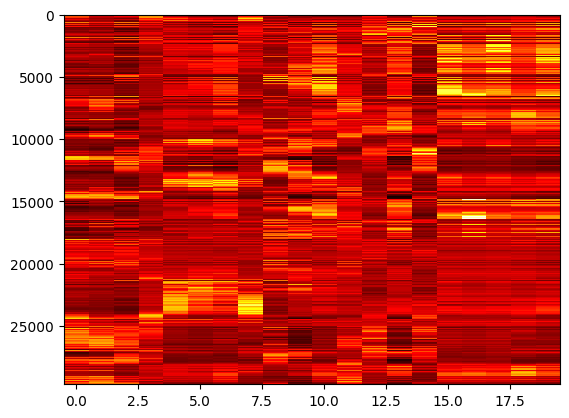

In [29]:
plt.imshow(fcpriors, cmap="hot", interpolation="nearest", aspect="auto")

In [3]:
maxprob_fc = np.argmax(fcpriors, axis=1).astype(int)
maxprob_sp = np.argmax(spatialpriors, axis=1).astype(int)

# compute jaccard between maxprob_fc and maxprob_sp
jaccard = np.sum(maxprob_fc == maxprob_sp) / len(maxprob_fc)

jaccard

np.float64(0.7702820978926816)

In [4]:
df = pd.DataFrame({"maxprob_fc": maxprob_fc, "maxprob_sp": maxprob_sp})


Text(0.5, 0, 'Proportion of vertices')

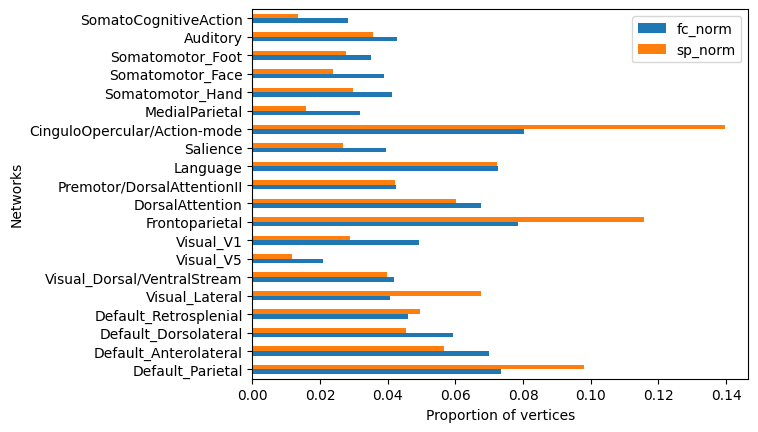

In [5]:
fc_counts = df.maxprob_fc.value_counts().sort_index()
fc_counts_norm = fc_counts / np.sum(np.isfinite(fcpriors), axis=0)
sp_counts = df.maxprob_sp.value_counts().sort_index()
sp_counts_norm = sp_counts / np.sum(np.isfinite(spatialpriors), axis=0)

count_df = pd.DataFrame({"fc_norm": fc_counts_norm, "sp_norm": sp_counts_norm})

ax = count_df.plot(kind="barh", stacked=False)
ax.set_ylabel("Networks")  # Add your desired x-axis label here
_ = ax.set_yticklabels(
    names[:20], ha="right"
)  # Add tick labels with rotation and alignment
ax.set_xlabel("Proportion of vertices")

In [68]:
# generate simulated affinity matrix based on the fc priors

matching_matrix = (maxprob_fc[:, None] == maxprob_fc).astype(np.float32)
# set diagonal to zero
np.fill_diagonal(matching_matrix, 0)

# create a z-scored version for use in generating noisy versions
matching_matrix_z = r_to_z(matching_matrix)

np.mean(matching_matrix)

np.float32(0.05603485)

In [69]:
thresh = .99
match_pairs = np.where(matching_matrix >= thresh)
match_pairs_clean = [
    (int(i), int(j)) for i, j in zip(match_pairs[0], match_pairs[1]) if i != j
]
del match_pairs

In [70]:
len(match_pairs_clean)

49447386

### Infomap

In [102]:
# create a graph from the matching matrix

def matching_matrix_to_graph(matching_matrix, density=.05):
    G = nx.Graph()
    G.add_nodes_from(range(matching_matrix.shape[0]))
    thresh = np.percentile(matching_matrix, 100 * (1 - density))
    match_pairs = np.where(matching_matrix >= thresh)
    match_pairs_clean = [
        (int(i), int(j)) for i, j in zip(match_pairs[0], match_pairs[1]) if i != j
    ]
    G.add_edges_from(match_pairs_clean)
    return G

G = matching_matrix_to_graph(matching_matrix, density=.05)



In [103]:
def run_infomap(G, true_labels, verbose=False):
    im = Infomap(silent=True)

    mapping = im.add_networkx_graph(G)
    im.run()
    if verbose:
        print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    module_id_dict = {node.node_id: node.module_id for node in im.tree if node.is_leaf}
    module_list = np.array([module_id_dict[i] for i in range(fcpriors.shape[0])])
    cm = confusion_matrix(true_labels, module_list)
    cm_argmax = cm.argmax(axis=0)
    module_list_relabeled = np.array([cm_argmax[i] for i in module_list])

    return module_list, module_list_relabeled


module_list, module_list_relabeled = run_infomap(G, maxprob_fc, verbose=True)
adjusted_rand_score(maxprob_fc, module_list)

Found 20 modules with codelength: 10.774711487008977


1.0

In [84]:
# add noise to the matching matrix
# cutoff is the maximum value for the true correlation

def create_noisy_matching_matrix(matching_matrix_z, noise_level=1, cutoff=0.6, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, noise_level, matching_matrix.shape)
    cutoff_z = r_to_z(cutoff)[0]
    matching_matrix_z_noisy = np.clip(matching_matrix_z, -1 * cutoff_z, cutoff_z) + noise
    matching_matrix_noisy = z_to_r(matching_matrix_z_noisy)
    return matching_matrix_noisy

matching_matrix_noisy = create_noisy_matching_matrix(matching_matrix_z, noise_level=.3)
G = matching_matrix_to_graph(matching_matrix_noisy, density=.05)

module_list = run_infomap(G, verbose=True)
adjusted_rand_score(maxprob_fc, module_list)


Found 10 modules with codelength: 14.048447690382332


0.5816861547076567

In [134]:
def get_module_counts(module_list, true_labels):
    modules = sorted(np.unique(true_labels).tolist())
    counter = {i:int(np.sum(module_list == i)) for i in modules}
    return counter

get_module_counts(module_list, maxprob_fc)

{0: 0,
 1: 0,
 2: 3019,
 3: 0,
 4: 1207,
 5: 0,
 6: 617,
 7: 1464,
 8: 2335,
 9: 2945,
 10: 0,
 11: 0,
 12: 1174,
 13: 10170,
 14: 0,
 15: 1224,
 16: 1154,
 17: 1038,
 18: 2518,
 19: 841}

In [136]:

results = []
nruns = 10

for noise_level in np.arange(0.1, 0.4, 0.1):
    for run in range(nruns):
        matching_matrix_noisy = create_noisy_matching_matrix(matching_matrix_z, noise_level=noise_level)
        G = matching_matrix_to_graph(matching_matrix_noisy, density=.05)
        module_list, module_list_relabeled = run_infomap(G, maxprob_fc, verbose=False)
        ari = adjusted_rand_score(maxprob_fc, module_list)
        results.append([noise_level, ari] + list(get_module_counts(module_list_relabeled, maxprob_fc).values()))
        print(f"Noise level: {noise_level}, ARI: {ari}")

ValueError: too many values to unpack (expected 2)

In [129]:
results

[[np.float64(0.1),
  0.6279407367919176,
  6824,
  2079,
  1761,
  1207,
  1244,
  617,
  4953,
  1258,
  2156,
  1174,
  2388,
  1224,
  1980,
  841],
 [np.float64(0.1),
  0.5782507132375901,
  3837,
  5236,
  1761,
  1365,
  1207,
  1464,
  4837,
  1174,
  5818,
  942,
  1224,
  841],
 [np.float64(0.1),
  0.7283718322633471,
  4261,
  1761,
  1365,
  1207,
  1244,
  617,
  2335,
  2003,
  2156,
  1174,
  5006,
  942,
  1224,
  3570,
  841],
 [np.float64(0.1),
  0.4698609427446013,
  3019,
  1207,
  617,
  1464,
  2335,
  2945,
  1174,
  10170,
  1224,
  1154,
  1038,
  2518,
  841]]

In [128]:
results_df = pd.DataFrame(results, columns=["noise_level", "ari"] + [f'size_mod{i}' for i in list(get_module_counts(module_list).keys())])

ValueError: 15 columns passed, passed data had 17 columns